# Demo of SpikeShip by using NWB data format

A short example using [AllenSDK](https://alleninstitute.github.io/AllenSDK/install.html) and SpikeShip dissimilarity measure to find temporal spiking patterns in NWB datasets.


We use NWB dataset as an example of using the SpikeShip algorithm. The first step consists in build another dataset with epochs (i.e, trial, time window) and spike times. This new structure follows the work called "SPOTDis" (Grossberger L., et al.) .

It consists of two data-structures:

1) The spike times vector (e.g. `spike_times = [0.2, 0.6, 0.65, 0.9, 1.1, 0.3, 0.9, 0.2]`) of type float with one entry for each spike.

2) The index matrix with the dimensions (#epochs, #neurons, 2) of type int where the last dimension contains a start and a stop index for the spike times vector, indicating which spikes belong to the selected epoch and neuron.

ii_spike_times = [
    # Epoch 1
    [
        # Neuron 1 -> spike(s) at time(s) 0.2, 0.6
        [0, 2],
        # Neuron 2 -> spike(s) at time(s) 0.65
        [2, 3],
        # Neuron 3 -> spike(s) at time(s) 0.9, 1.1
        [3, 5],
    ],
    # Epoch 2
    [
        # Neuron 1 -> spike(s) at time(s) 0.3
        [5, 6],
        # Neuron 2 -> spike(s) at time(s) 0.9
        [6, 7],
        # Neuron 3 -> spike(s) at time(s) 0.2
        [8, 9],
    ],
]

The spike times for a given epoch e and neuron n can be retrieved from the spike times vector using the index matrix as follows:
```epoch_neuron_spike_times = spike_times[ii_spike_times[e, n, 0]:ii_spike_times[e, n, 1]]
```

Check [SPOTDis Demo](https://github.com/LGro/spot/blob/master/notebooks/SPOTDisClust_Demo.ipynb) for more information.


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# warnings from jupyter notebook
import warnings
warnings.filterwarnings('ignore')

---

## Preprocessing


Download an example of NWB data from brain-map API.

In [2]:
# !wget http://api.brain-map.org//api/v2/well_known_file_download/1026124216

In [3]:
from spikeship import data_formatter
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

# Load the session downloaded previouly
session = EcephysSession.from_nwb_path('1026124216')

# Get the spike_times (dict) from the nwb session
nwb_ds = np.array(session.spike_times)

We need to create two vectors: a vector of neuron ids `v_neuron_ids`, and a vector for the spike times `v_spike_times`. Neurons ids have to be renamed as integer values from $0$ to $N-1$, with $N$ the number of neurons.

In [4]:
# Getting spike times and neuron ids as two separated vectors from NWB dataset
print ("Getting spike times and neuron ids as two separated vectors from NWB dataset")
v_neuron_ids  = [] # vect of neurons
v_spike_times = [] # vect of spike times
c = 0
d_neuron_rename = {}
for neuron_id, spks in nwb_ds.item().items():
    # renaming neuron_ids
    for ii in range(len(nwb_ds.item().keys())):
        if not neuron_id in d_neuron_rename:
            d_neuron_rename[neuron_id] = c
            c += 1
    # compute each spike time for neuron
    for val in spks:
        v_neuron_ids.append( int(neuron_id) )
        v_spike_times.append( float(val) )

v_neuron_ids  = np.array([ d_neuron_rename[neuron] for neuron in v_neuron_ids ] )
v_spike_times = np.array(v_spike_times)

print ('v_neuron_ids ', v_neuron_ids)
print ('v_spike_times', v_spike_times)

Getting spike times and neuron ids as two separated vectors from NWB dataset
v_neuron_ids  [  0   0   0 ... 683 683 683]
v_spike_times [7.10436448e+00 7.39789797e+00 8.57829858e+00 ... 9.96599338e+03
 9.96607615e+03 9.96614198e+03]


### Data Formatting
Definition of number of `epochs` and time window length (i.e., `time_slide_length`).

In this step, we define the local analysis. In this example, we select for the first 1000 seconds of analysis (See variables `ds_min_t` and `ds_max_t`).

Each epoch (i.e., temporal window or trial( has a length of `time_slide_length = 5` seconds.
We use the method called `data_formatter.allocate_spikes` to convert the data into the SPOTDis and SpikeShip data format. This method returns a new dataset with intermediate epochs that contains an overlap between the previous and posterior epoch. For instance, in this scenario the first epoch considers the time from $0.0$ to $3.0$s and the third epoch goes from $3.0$ to $6.0$s. Thus, the second epoch is defined from $1.5$ to $4.5$s.

In [5]:
# Define local analysis.
ds_min_t = 3               # start point for time window
ds_max_t = 1000 + ds_min_t # end point for time window
time_slide_length = 5      # time window length (5 secs)

# definition of parameters for 'allocate_spikes' method
# number of chunks (epochs)
n_max_chunks = int(np.ceil( (2*(ds_max_t - ds_min_t)) / time_slide_length ) - 1) # total number of chunks or epochs
chunk_increment = time_slide_length / 2. # overlapping
total_spikes  = len(v_spike_times)
total_neurons = len([item for item in nwb_ds.item()])

print ('total_neurons', total_neurons)
print ('total_spikes', total_spikes)
print ('v_spike_times min:', np.min(v_spike_times))
print ('v_spike_times max:', np.max(v_spike_times))
print ('ds_min_t selected:', ds_min_t)
print ('ds_max_t selected:', ds_max_t)
print ('# epochs', n_max_chunks)

total_neurons 684
total_spikes 61068666
v_spike_times min: 3.7769172773781765
v_spike_times max: 9966.263082538046
ds_min_t selected: 3
ds_max_t selected: 1003
# epochs 399


In [6]:
ii_spike_times, spike_times = data_formatter.allocate_spikes(
    v_spike_times, total_spikes,v_neuron_ids, n_max_chunks, chunk_increment,ds_min_t,total_neurons, time_slide_length
)
print('[INFO] total spike_times',len(spike_times), 'total epochs', ii_spike_times.shape[0])

[INFO] total spike_times 61068666 total epochs 399


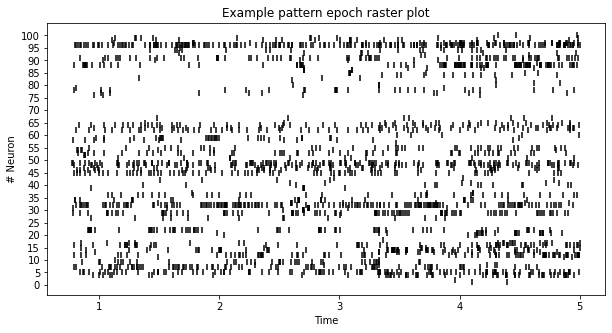

In [7]:
f, ax = plt.subplots(figsize=(10,5))

ax.set_title('Example pattern epoch raster plot')

i_epoch = 0 # selected epoch for plotting
n_neurons = 100

for i_neuron in range(n_neurons):
    tmp_epoch_neuron_spike_times = spike_times[
        ii_spike_times[i_epoch, i_neuron, 0]:ii_spike_times[i_epoch, i_neuron, 1]]
    ax.scatter(tmp_epoch_neuron_spike_times, np.ones(len(tmp_epoch_neuron_spike_times))+i_neuron,
               marker='|', c='black')

ax.set_yticks(np.arange(0, n_neurons+1, 5))
ax.set_ylabel('# Neuron')
ax.set_xlabel('Time');

---
## SpikeShip
### Computation

In [8]:
from spikeship import spikeship

In [9]:
%%time
# computation of neuron specific-flows (ss_dissimilarities) and optimal global flow (G)
dissimilarity, G = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 7min 21s, sys: 837 ms, total: 7min 22s
Wall time: 42.2 s


### Visualization

In [10]:
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#### HDBSCAN Computation

In [11]:
np.random.seed(0)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels_dis = clusterer.fit_predict(dissimilarity)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels_G = clusterer.fit_predict(G)

print ('%i clusters found in neuron-specific dissimilarity matrix' % len(set(cluster_labels_dis)))
print ('%i clusters found in global shift dissimilarity matrix' % len(set(cluster_labels_G)))

3 clusters found in neuron-specific dissimilarity matrix
1 clusters found in global shift dissimilarity matrix


#### t-SNE Computation

In [12]:
tsne_model = TSNE(metric='precomputed', n_components=2)
embedding_dis  = tsne_model.fit_transform(dissimilarity)
embedding_g    = tsne_model.fit_transform(np.absolute(G))

#### Plotting matrices about the neuron-specific shifts and the optimal global flow

<Figure size 432x288 with 0 Axes>

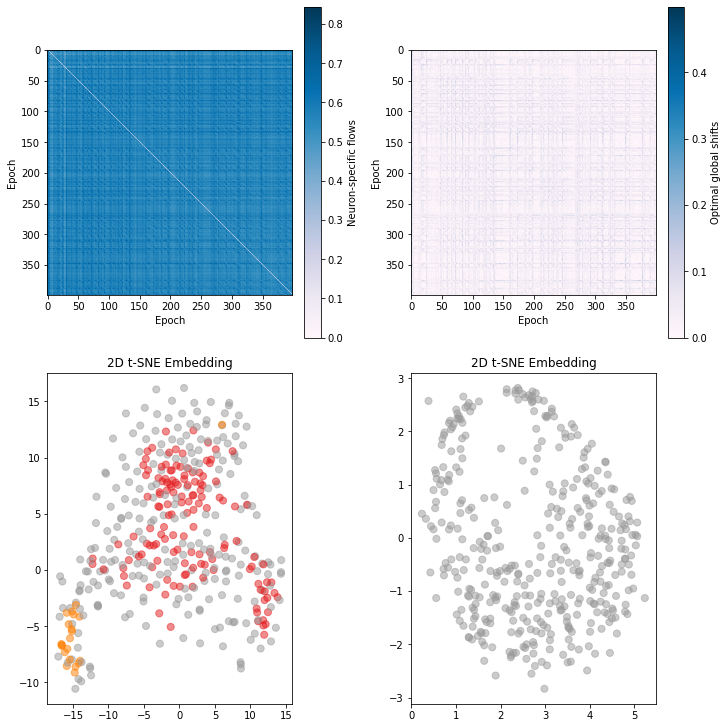

In [13]:
plt.clf()
alpha = 0.5
marker = 'o'
tPlot, axes = plt.subplots(
    figsize = (10,10),
    nrows=2, ncols=2, sharex=False, sharey=False, 
    constrained_layout=True
    )

# dissimilarity matrix (vis)
im0 = axes[0][0].imshow(dissimilarity, cmap='PuBu')
axes[0][0].set_xlabel('Epoch')
axes[0][0].set_ylabel('Epoch');
plt.colorbar(im0, ax=axes[0][0], label='Neuron-specific flows')

im1 = axes[0][1].imshow(np.absolute(G), cmap='PuBu')
axes[0][1].set_xlabel('Epoch')
axes[0][1].set_ylabel('Epoch');
plt.colorbar(im1, ax=axes[0][1], label='Optimal global shifts')

# 2D tsne embedding (vis)
axes[1][0].set_title('2D t-SNE Embedding')
axes[1][0].scatter(embedding_dis[:, 0], embedding_dis[:, 1], cmap='Set1_r', s=50,c=cluster_labels_dis, alpha=alpha, marker=marker, facecolors='none')

axes[1][1].set_title('2D t-SNE Embedding')
axes[1][1].scatter(embedding_g[:, 0], embedding_g[:, 1], cmap='Set1_r', s=50,c=cluster_labels_G, alpha=alpha, marker=marker, facecolors='none');


---

## Comparison with SPOTDis
In order to test the SPOTDis module, follow the instruction in the github repository of its author: https://github.com/LGro/spot/blob/master/notebooks/SPOTDisClust_Demo.ipynb

In [14]:
from spot import spot

In [ ]:
%%time
diss_spot = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')

#### HDBSCAN Computation

In [ ]:
np.random.seed(0)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels_dis = clusterer.fit_predict(diss_spot)

#### tSNE Computation

In [ ]:
tsne_model = TSNE(metric='precomputed', n_components=2)
embedding_dis  = tsne_model.fit_transform(diss_spot)

In [ ]:
plt.clf()
alpha = 0.5
marker = 'o'
tPlot, axes = plt.subplots(
    figsize = (10,10),
    nrows=2, ncols=2, sharex=False, sharey=False, 
    constrained_layout=True
    )
# dissimilarity matrix (vis)
im0 = axes[0][0].imshow(dissimilarity, cmap='PuBu')
axes[0][0].set_xlabel('Epoch')
axes[0][0].set_ylabel('Epoch');
plt.colorbar(im0, ax=axes[0][0])

# 2D tsne embedding (vis)
axes[1][0].set_title('2D t-SNE Embedding')
axes[1][0].scatter(embedding_dis[:, 0], embedding_dis[:, 1], cmap='Set1_r', s=50,c=cluster_labels_dis, alpha=alpha, marker=marker, facecolors='none')


In order to compute the dissimilarity between two pairs of epochs, SPOTDis has a computational complexity of $\mathcal{O}(N^2n^2)$, where $M$ is the number of epochs or trials, $N$ is the number of active Neurons, and $n$ the average spikes per epoch. In contrast, SpikeShip has a computational complexity of $\mathcal{O}(Nn)$ (Quadratic speed-up).


---
Check our paper for more details:

Sotomayor-Gómez, B., Battaglia, F. P., & Vinck, M. (2020). [A geometry of spike sequences: Fast, unsupervised discovery of high-dimensional neural spiking patterns based on optimal transport theory](https://doi.org/10.1101/2020.06.03.131573). *bioRxiv*.